In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gym
from tensorflow import keras
import numpy as np
import matplotlib.animation as animation
import matplotlib as mpl


In [2]:
env = gym.make("LunarLander-v2")

In [3]:
#first we need to initialize the environment by calling is reset() method.
env.seed(32)
obs = env.reset()
print("Observations", obs) 


Observations [-0.00285311  1.4188244  -0.2890017   0.35130486  0.00331281  0.06546324
  0.          0.        ]


In [4]:
#The environment  tells us how much reward got the agent during the last step  
action = env.action_space.sample()         
next_state, reward, done, info = env.step(action)

In [5]:
     
print("Stage -> ", next_state)
print("action: ",action)
print("Reward: ",reward)
print(done)
print(info)

Stage ->  [-0.0057065   1.4261507  -0.2886104   0.32559812  0.00654771  0.06470464
  0.          0.        ]
action:  0
Reward:  0.9235896771213561
False
{}


In [6]:
#run the lunar lander 

episodes = 20
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()


Episode:1 Score:-294.14572806246474
Episode:2 Score:-226.28877357879895
Episode:3 Score:-207.94446108594553
Episode:4 Score:-179.73220919429716
Episode:5 Score:-84.67543053760262
Episode:6 Score:-190.31103653620067
Episode:7 Score:-130.00884490013146
Episode:8 Score:-118.18640910685221
Episode:9 Score:-140.28358196984146
Episode:10 Score:-120.64333186195401
Episode:11 Score:-108.32463263787216
Episode:12 Score:-235.44430004435614
Episode:13 Score:-132.15822280951716
Episode:14 Score:-121.79710513323731
Episode:15 Score:-119.17608198595248
Episode:16 Score:-170.40140123113065
Episode:17 Score:-167.79476810993162
Episode:18 Score:-90.4967028873276
Episode:19 Score:-288.53900397738016
Episode:20 Score:-126.0498388829304


In [7]:
#1. do nothing   2. fire left engine   3.fire  main/down engine  4. fire right engine 
actions = env.action_space.n
print("Actions", actions)



print("Observation Space is ", env.observation_space.shape[0])


Actions 4
Observation Space is  8


In [8]:
#The environment  tells us how much reward got the agent  during the last step
action = env.action_space.sample()         
next_state, reward, done, info = env.step(action)
            
     
print("Next Stage is ->", next_state)
print("Action -> ", action)
print(reward)
print(done)
print(info)


Next Stage is -> [ 5.0394756e-01 -1.5597460e-01  4.5527926e-01  1.6800765e-02
  5.5516575e-02  2.6799989e-09  0.0000000e+00  0.0000000e+00]
Action ->  3
-100
True
{}


In [9]:
print(env.observation_space.low)

print(env.observation_space.high)

[-inf -inf -inf -inf -inf -inf -inf -inf]
[inf inf inf inf inf inf inf inf]


In [10]:
# Create a simple policy network with 4 output neurons (one per possible action) that use the Model class in the keras.models. [15 points]

keras.backend.clear_session()
np.random.seed(42)

tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0] # (8,)
n_outputs = env.action_space.n     # 4


model = keras.models.Sequential([
            keras.layers.Dense( 32, activation="relu", input_shape=[n_inputs] ),
            keras.layers.Dense( 32, activation="relu" ),
            keras.layers.Dense( n_outputs, activation="softmax" ),
        ])

def lander_play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape:
    probas = model( obs[np.newaxis] ) # obs[np.newaxis] ==> (batch_size, observation)
    logits = tf.math.log( probas + keras.backend.epsilon() )
    # num_samples : Number of independent samples to draw for each row slice.
    # tf.random.categorical : The drawn samples of shape [batch_size, num_samples].
    action = tf.random.categorical( logits, num_samples=1 ) # select an action index for each sample
    loss = tf.reduce_mean( loss_fn(action, probas) )
  grads = tape.gradient( loss, model.trainable_variables )
  obs, reward, done, info = env.step( action[0,0].numpy() )
  return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn ):
  all_rewards = []
  all_grads = []

  for episode in range( n_episodes ):
    current_rewards = []
    current_grads = []
    obs = env.reset()

    for step in range( n_max_steps ):
      obs, reward, done, grads = lander_play_one_step( env, obs, model, loss_fn )
      current_rewards.append( reward )
      current_grads.append( grads )
      if done:
        break
        
    all_rewards.append( current_rewards )
    all_grads.append( current_grads )

  return all_rewards, all_grads


def discount_rewards( rewards, discount_rate ):
  discounted = np.array( rewards )
  # from back to front that to avoid use a recursion
  for step in range( len(rewards)-2, -1, -1 ): # except last_reward(use itself): len(rewards)-1
    discounted[step] += discounted[step+1] * discount_rate
  return discounted

In [11]:
# To normalize all discounted rewards across all episodes
def discount_and_normalize_rewards( all_rewards, discount_rate ):
  all_discounted_rewards = [ discount_rewards(rewards, discount_rate)
                             for rewards in all_rewards
                           ]
  flat_rewards = np.concatenate( all_discounted_rewards ) # []+...[]=>[]
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()

  return[ (discounted_rewards - reward_mean)/reward_std
          for discounted_rewards in all_discounted_rewards
        ]  


In [12]:
#Discuss the rationale of the activation functions used in the network. [10 points]
optimizer = keras.optimizers.Nadam(learning_rate = 0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [14]:
#Implement a strategy that adjusts the following hyperparameters: (i) the number of iterations, (ii) the number of episodes, (iii) the maximum number of steps, and (iv) the discount factor 

n_iterations = 50 
n_episodes_per_update = 16 
n_max_steps = 1000 
discount_rate = 0.99


env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
  all_rewards, all_grads = lander_play_multiple_episodes( env,
                                                          n_episodes_per_update,
                                                          n_max_steps,
                                                          model,
                                                          loss_fn
                                                        )
  mean_reward = sum( map(sum, all_rewards) ) / n_episodes_per_update
  print( "\rIteration: {}/{}, mean reward: {:.1f} ".format( iteration+1, 
                                                            n_iterations, 
                                                            mean_reward 
                                                          ),
        end = ""
       )
  mean_rewards.append(mean_reward)
    
    

  all_final_rewards = discount_and_normalize_rewards( all_rewards, discount_rate)
  
  all_mean_grads = []
  for var_index in range( len(model.trainable_variables) ):
    mean_grads = tf.reduce_mean(
        [ final_reward * all_grads[episode_index][step][var_index]
          for episode_index, final_rewards in enumerate( all_final_rewards )
            for step, final_reward in enumerate( final_rewards )
        ],
        axis=0  
    )
    all_mean_grads.append( mean_grads )
    
  optimizer.apply_gradients( zip( all_mean_grads, model.trainable_variables ) )


Iteration: 50/50, mean reward: -20.1  

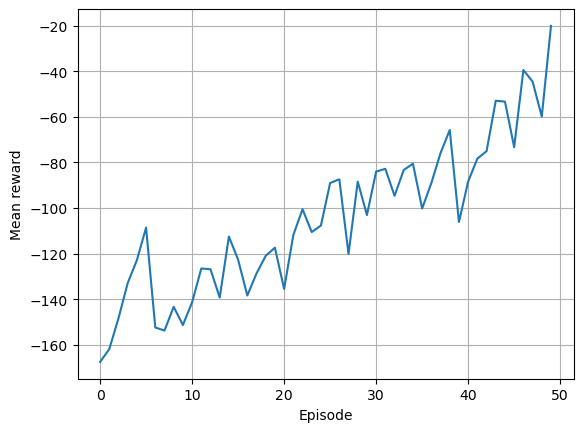

In [15]:
#Provide the parameters of the worst and best network policy and plot their corresponding Mean reward on the y-axis to Episode on the x-axis. [15 points]


plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()

plt.show()

In [25]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [26]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [27]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)